# Survey Analyzer

## Introduction
The goal of this notebook is to analyze and inspect the students' mutation tools survey.

In this survey 7 (seven) questions were asked to each group of students, to which they could
answer with a score from 1 to 5 (and they were allowed also to add some comments to their answer).

Block of texts will occur where needed in the notebook.

## Import

First we need to import `pandas` and read the sheets of the Excel file created ad-hoc for this task.

The link to the file is: https://docs.google.com/spreadsheets/d/1pMirFCTNX-HA9h3MX4Y7l-N8eRsp_UkgtNHd4gCEBow

Sheet2 contains the results of the survey, while Sheet3 contains our own coverage scores got
from the command `defects4j coverage` executed in the three projects under test (Cli32, Gson15, Lang53) roots.

In [61]:
import pandas as pd

survey_original = pd.read_csv("survey/Sheet2.csv")
coverage_original = pd.read_csv("survey/Sheet3_dev.csv")

Then we need to manipulate these objects, starting from coverage.

In [62]:
coverage_original.head()

,Tool,Groups,Project,Coverage (only student),Unnamed: 4,Coverage (only dev),Unnamed: 6,Coverage (student + dev),Unnamed: 8
0,NaN,NaN,NaN,Line,Branch,Line,Branch,Line,Branch
1,Judy,D3 D1 A2 B7,Cli,1,"0,9824561404","0,9651741294","0,9298245614",1,"0,9824561404"
2,NaN,B7 A2 B4 D3,Gson,"0,9847715736","0,9787234043","0,9644670051","0,9361702128","0,9949238579","0,9893617021"
3,NaN,B4 D1 A4,Lang,"0,75","0,7542857143","0,9711538462","0,9028571429","0,9759615385","0,9371428571"
4,Jumble,A5 B3 D2 A6,Cli,"0,8805970149","0,798245614","0,9651741294","0,9298245614",1,"0,9824561404"


As we can see, the first row is useless, and the tool column has some Nans because of grouping cells together.

In this block below we fix those problems, and also removes the Groups column.

In [63]:
# take only columns needed and then fill nan values (tool) with forward fill
coverage = coverage_original.drop(columns=["Groups"]).iloc[1:,:].fillna(method="ffill")

# convert string to float (because of , in number instead of .)
coverage.iloc[:, 2:] = coverage.iloc[:, 2:].applymap(lambda x: float(x.replace(",", ".")))

# change columns
# Line = Line Coverage, Branch = Branch Coverage
# All refers to coverage obtained from both Students and original Developers's testsuites
coverage.columns = ["Tool", "Project", "LineStud", "BranchStud", "LineDev", "BranchDev", "LineAll", "BranchAll"]

coverage = coverage.set_index("Tool")
coverage

,Project,LineStud,BranchStud,LineDev,BranchDev,LineAll,BranchAll
Tool,,,,,,,
Judy,Cli,1.000000,0.982456,0.965174,0.929825,1.000000,0.982456
Judy,Gson,0.984772,0.978723,0.964467,0.936170,0.994924,0.989362
Judy,Lang,0.750000,0.754286,0.971154,0.902857,0.975962,0.937143
Jumble,Cli,0.880597,0.798246,0.965174,0.929825,1.000000,0.982456
Jumble,Gson,0.954315,0.872340,0.964467,0.936170,1.000000,1.000000
Jumble,Lang,0.581731,0.531429,0.971154,0.902857,0.990385,0.908571
Major,Cli,0.895522,0.894737,0.965174,0.929825,1.000000,0.991228
Major,Gson,0.969543,0.978723,0.964467,0.936170,1.000000,1.000000
Major,Lang,0.985577,0.982857,0.971154,0.902857,0.985577,0.982857


The `coverage` dataframe has, as possible groups, both project (Cli, Gson, Lang) and tool
(Judy, Jumble, Major, Pit).

To take into account both of them, we can inspect the ration between Dev and All.
Dev takes into account the original dev testsuite, while All both dev and students testsuite.

Let's then create some proposal; after some reasoning, we will choose the best candidate.
We create them grouping over a key, and then taking the mean as metric.

In [64]:
proposals = [
    coverage.groupby(["Project"]).mean(),
    coverage.groupby(["Tool"]).mean(),
    coverage.groupby(["Tool", "Project"]).mean(),
    coverage.groupby(["Project", "Tool"]).mean()
]

The first dataframe has Project as primary key.

This solution blurs the choosen tool into the project, so it can't be the best choice.

In [65]:
proposals[0]

,LineStud,BranchStud,LineDev,BranchDev,LineAll,BranchAll
Project,,,,,,
Cli,0.891791,0.855263,0.965174,0.929825,1.000000,0.986842
Gson,0.964467,0.906915,0.964467,0.936170,0.998731,0.997340
Lang,0.789663,0.771429,0.971154,0.902857,0.986779,0.954286


The second dataframe has Tool as primary key.

This solution leads us to both LineDev and BranchDev constants, so these columns are devoid of information;
that's because for every tool we always have three equals rows, that are line and branch coverage
for the project under test; because these three rows are equals and replicated over the four tools,
then the mean for every tool is equal and therefore the columns are constant.

We can make a comparison between Stud and All, because Stud changes its value from group to group (and so
from project to project), while All takes into account also Dev testsuite.

In [66]:
proposals[1]

,LineStud,BranchStud,LineDev,BranchDev,LineAll,BranchAll
Tool,,,,,,
Judy,0.911591,0.905155,0.966932,0.922951,0.990295,0.969654
Jumble,0.805548,0.734005,0.966932,0.922951,0.996795,0.963676
Major,0.950214,0.952106,0.966932,0.922951,0.995192,0.991362
PIT,0.860543,0.786876,0.966932,0.922951,0.998397,0.993266


The third dataframe has Tool as primary key and Project as secondary.

Even though this dataframe don't lose precision (because it reflects the original schema), it's almost useless
for the same reason; we aren't grouping anything, and so we aren't extracting any peculiar information.

In [67]:
proposals[2]

LineStud  BranchStud   LineDev  BranchDev   LineAll  BranchAll
Tool   Project                                                                
Judy   Cli      1.000000    0.982456  0.965174   0.929825  1.000000   0.982456
       Gson     0.984772    0.978723  0.964467   0.936170  0.994924   0.989362
       Lang     0.750000    0.754286  0.971154   0.902857  0.975962   0.937143
Jumble Cli      0.880597    0.798246  0.965174   0.929825  1.000000   0.982456
       Gson     0.954315    0.872340  0.964467   0.936170  1.000000   1.000000
       Lang     0.581731    0.531429  0.971154   0.902857  0.990385   0.908571
Major  Cli      0.895522    0.894737  0.965174   0.929825  1.000000   0.991228
       Gson     0.969543    0.978723  0.964467   0.936170  1.000000   1.000000
       Lang     0.985577    0.982857  0.971154   0.902857  0.985577   0.982857
PIT    Cli      0.791045    0.745614  0.965174   0.929825  1.000000   0.991228
       Gson     0.949239    0.797872  0.964467   0.936170  1.000000   1.000000
       Lang     0.841346    0.817143  0.971154   0.902857  0.995192   0.988571

The fourth dataframe has Project as primary key and Tool as secondary.

Similiar to the third one, it has the same pros and cons.

In [68]:
proposals[3]

LineStud  BranchStud   LineDev  BranchDev   LineAll  BranchAll
Project Tool                                                                  
Cli     Judy    1.000000    0.982456  0.965174   0.929825  1.000000   0.982456
        Jumble  0.880597    0.798246  0.965174   0.929825  1.000000   0.982456
        Major   0.895522    0.894737  0.965174   0.929825  1.000000   0.991228
        PIT     0.791045    0.745614  0.965174   0.929825  1.000000   0.991228
Gson    Judy    0.984772    0.978723  0.964467   0.936170  0.994924   0.989362
        Jumble  0.954315    0.872340  0.964467   0.936170  1.000000   1.000000
        Major   0.969543    0.978723  0.964467   0.936170  1.000000   1.000000
        PIT     0.949239    0.797872  0.964467   0.936170  1.000000   1.000000
Lang    Judy    0.750000    0.754286  0.971154   0.902857  0.975962   0.937143
        Jumble  0.581731    0.531429  0.971154   0.902857  0.990385   0.908571
        Major   0.985577    0.982857  0.971154   0.902857  0.985577   0.982857
        PIT     0.841346    0.817143  0.971154   0.902857  0.995192   0.988571

After presenting the proposal, we chose the second (grouping over Tool).

In [69]:
proposal = proposals[1]
coverage_grouped = proposal.copy()
proposal

,LineStud,BranchStud,LineDev,BranchDev,LineAll,BranchAll
Tool,,,,,,
Judy,0.911591,0.905155,0.966932,0.922951,0.990295,0.969654
Jumble,0.805548,0.734005,0.966932,0.922951,0.996795,0.963676
Major,0.950214,0.952106,0.966932,0.922951,0.995192,0.991362
PIT,0.860543,0.786876,0.966932,0.922951,0.998397,0.993266


We note in the newly generated dataframe that, for Judy and Major, we have values very close to unity,
even the branch coverage of Stud (Major) is higher than that of Dev.

As for Jumble and Pit, however, we are more distant from the results of the Devs; this
it may be a symptom of worse usability of the tools, but not necessarily - this
in fact it depends on the Studs, if they have used these two tools together with the Dev testsuite
to kill the generated mutants (and therefore have not tried to improve the results of theirs
testsuite), or if the instrument was really inadequate and therefore the scores are lower.

 Let's now read the results of the students' survey in tabular form.

The columns have been renamed due to their high length in Tool, Projects, and Mi (where Mi is the
i-th metric requested in the survey; The seven metrics required in the survey are listed below
to the students).

- M1: How easy was it to install the mutation testing tool?
- M2: How easy was it to configure the mutation testing tool to work with your subjects?
- M3: How easy was it to generate mutants?
- M4: How easy was it to determine what mutation operator generated which mutant?
- M5: How easy was it to implement tests for killable generated mutants?
- M6: How easy was it to identify equivalent generated mutants?
- M7: How easy was it to use the mutation testing tool to run the tests against the generated mutants?

In [70]:
survey = survey_original.iloc[:, 1:-4]
cols = survey.columns
print(f"Old columns are {cols}")
_ = [
    "Tool",
    "Projects",
    "MInstall",
    "MConfig",
    "MGeneration",
    "MOperator",
    "MTests",
    "MEquiv",
    "MUsage",
]
new_cols = [
    "Tool",
    "Projects",
    "M1",
    "M2",
    "M3",
    "M4",
    "M5",
    "M6",
    "M7",
]
survey.columns = new_cols
print("Changed columns")

# drop projects col
# survey.drop(columns="Projects", inplace=True)

survey

Old columns are Index(['Which mutation testing tool did you use? ',
       'Which Defects4J project did you test?',
       'How easy was it to install the mutation testing tool?',
       'How easy was it to configure the mutation testing tool to work with your subjects?',
       'How easy was it to generate mutants?',
       'How easy was it to determine what mutation operator generated which mutant?',
       'How easy was it to implement tests for killable generated mutants?',
       'How easy was it to identify equivalent generated mutants?',
       'How easy was it to use the mutation testing tool to run the tests against the generated mutants?'],
      dtype='object')
Changed columns


,Tool,Projects,M1,M2,M3,M4,M5,M6,M7
0,Judy,"Cli, Gson",5,5,5,5,2,3,2
1,Judy,"Cli, Gson",5,4,3,1,1,1,5
2,Judy,"Cli, Gson",5,5,5,1,1,1,5
3,Judy,"Cli, Gson",4,4,3,2,1,1,1
4,Judy,"Cli, Lang",2,2,4,1,1,2,1
5,PIT,"Gson, Lang",3,3,5,4,5,2,5
6,PIT,"Cli, Gson",5,5,5,5,3,3,5
7,PIT,"Gson, Lang",5,5,5,5,4,3,5
8,PIT,"Cli, Lang",4,3,5,3,2,2,5
9,Jumble,"Cli, Lang",3,3,4,3,4,2,2


As before, we could make considerations on which key (or keys) to use to group the obtained data;
since, however, the purpose is to evaluate the performances obtained by the different groups on the single tool,
the most logical choice is to group by Tool (excluding the Projects column in its entirety) e
analyze the scores obtained.

So let's set the Tool as an index, eliminating the Projects column.

In [71]:
survey_df = survey.set_index("Tool").drop(columns="Projects")
survey_df

,M1,M2,M3,M4,M5,M6,M7
Tool,,,,,,,
Judy,5,5,5,5,2,3,2
Judy,5,4,3,1,1,1,5
Judy,5,5,5,1,1,1,5
Judy,4,4,3,2,1,1,1
Judy,2,2,4,1,1,2,1
PIT,3,3,5,4,5,2,5
PIT,5,5,5,5,3,3,5
PIT,5,5,5,5,4,3,5
PIT,4,3,5,3,2,2,5


Since, unlike the previous case, even within the same tool the opinions were very discordant, it was preferred to use the median instead of the average as a grouping operation, in order not to let outlier values particularly affect the result.

In fact, we can see from the plot below how the error, for some tools and measures, is very high, and therefore the average would not approximate well the behavior of the series.

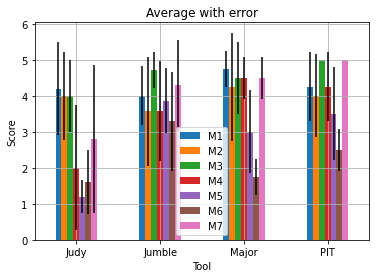

In [72]:
grouped = survey_df.groupby("Tool")

y = grouped.mean()
err = grouped.std()

# plot series mean with std err
ax = y.plot.bar(yerr=err, grid=True, rot=0)
ax.set_ylabel("Score")
ax.set_title(f"Average with error");

Below is the dataframe obtained by grouping and median operation on the columns.

In [73]:
survey_grouped = grouped.median()
survey_grouped

,M1,M2,M3,M4,M5,M6,M7
Tool,,,,,,,
Judy,5.0,4.0,4.0,1.0,1.0,1.0,2.0
Jumble,4.0,3.0,5.0,4.0,4.0,3.0,5.0
Major,5.0,5.0,5.0,4.5,3.0,2.0,4.5
PIT,4.5,4.0,5.0,4.5,3.5,2.5,5.0


Below you can see the dataframe obtained as a join of the two analyzed dataframes (survey and coverage),
with the intersection performed on the Tool key.

In [74]:
joined = survey_grouped.join(coverage_grouped)
joined

,M1,M2,M3,M4,M5,M6,M7,LineStud,BranchStud,LineDev,BranchDev,LineAll,BranchAll
Tool,,,,,,,,,,,,,
Judy,5.0,4.0,4.0,1.0,1.0,1.0,2.0,0.911591,0.905155,0.966932,0.922951,0.990295,0.969654
Jumble,4.0,3.0,5.0,4.0,4.0,3.0,5.0,0.805548,0.734005,0.966932,0.922951,0.996795,0.963676
Major,5.0,5.0,5.0,4.5,3.0,2.0,4.5,0.950214,0.952106,0.966932,0.922951,0.995192,0.991362
PIT,4.5,4.0,5.0,4.5,3.5,2.5,5.0,0.860543,0.786876,0.966932,0.922951,0.998397,0.993266


In [86]:
j = joined.copy()

# create line coverage delta
j["LineDelta"] = j["LineAll"] - j["LineDev"]
j["LineDeltaPerc"] = j["LineDelta"] / max(j["LineDelta"])

# create branch coverage delta
j["BranchDelta"] = j["BranchAll"] - j["BranchDev"]
j["BranchDeltaPerc"] = j["BranchDelta"] / max(j["BranchDelta"])

# visualize
j

,M1,M2,M3,M4,M5,M6,M7,LineStud,BranchStud,LineDev,BranchDev,LineAll,BranchAll,LineDelta,LineDeltaPerc,BranchDelta,BranchDeltaPerc
Tool,,,,,,,,,,,,,,,,,
Judy,5.0,4.0,4.0,1.0,1.0,1.0,2.0,0.911591,0.905155,0.966932,0.922951,0.990295,0.969654,0.023363,0.742504,0.046703,0.664188
Jumble,4.0,3.0,5.0,4.0,4.0,3.0,5.0,0.805548,0.734005,0.966932,0.922951,0.996795,0.963676,0.029863,0.949070,0.040725,0.579175
Major,5.0,5.0,5.0,4.5,3.0,2.0,4.5,0.950214,0.952106,0.966932,0.922951,0.995192,0.991362,0.028261,0.898139,0.068411,0.972911
PIT,4.5,4.0,5.0,4.5,3.5,2.5,5.0,0.860543,0.786876,0.966932,0.922951,0.998397,0.993266,0.031466,1.000000,0.070316,1.000000
